# HRI data analysis
## Import data files
### Experiment logs

In [1]:
import pathlib
import pandas as pd
import json
import functools
from tqdm.notebook import tqdm
import numpy as np


def readrun(df):
    frames = {}
    for _, r in df.iterrows():
        frames[r["ts"]] = pd.DataFrame(r["dict"].values())
    df = pd.concat(frames, names=["ts", "box"]).reset_index()
    df["ts"] = pd.to_datetime(df["ts"])
    return df.set_index(["ts", "box"])


@functools.cache
def readfile(fn):
    with open(fn) as f:
        d = f.read()
    d = d.split(sep="\n")
    metadata = eval(d[0])
    # print(metadata)
    d = pd.DataFrame(
        [r.split(", ", maxsplit=2) for r in d[1:-1]], columns=["ts", "n", "dict"]
    )
    d["n"] = pd.to_numeric(d["n"])
    d["dict"] = d["dict"].map(eval)
    df = d.groupby("n").apply(readrun)
    return df


ddir = pathlib.Path("logs_laboratory")
fns = ddir.glob("*.txt")
data = []
alldata = {}
for fn in tqdm(list(fns)):
    print(fn)
    df = readfile(fn)
    alldata[fn] = df
    # nok = df.groupby(level=["n", "ts"]).apply(
    #    lambda x: x[x["type"] == 1]["selected"].mean()
    # )
    # ctimes = nok.groupby(level="n").apply(lambda x: x.idxmax()[1] - x.index[0][1])
    # data.append(dict(fn=fn.name, ctime=ctimes.mean()))
# pd.DataFrame(data)

logs_laboratory\2021-02-25T15_31_24_1_real_static_gabri.txt
logs_laboratory\2021-02-25T16_01_23_1_gui_static_gabri.txt
logs_laboratory\2021-02-25T16_09_02_2_real_static_gabri.txt
logs_laboratory\2021-02-25T16_12_14_2_gui_static_gabri.txt
logs_laboratory\2021-02-25T16_14_12_3_real_static_gabri.txt
logs_laboratory\2021-02-25T16_16_26_3_gui_static_gabri.txt
logs_laboratory\2021-02-25T16_33_44_1_real_moving_gabri.txt
logs_laboratory\2021-02-25T16_35_18_1_gui_moving_gabri.txt
logs_laboratory\2021-02-25T16_37_19_3_gui_moving_gabri.txt
logs_laboratory\2021-02-25T16_39_17_3_real_moving_gabri.txt
logs_laboratory\2021-02-25T16_51_37_1_gui_static_jerome.txt
logs_laboratory\2021-02-25T16_53_34_1_real_static_jerome.txt
logs_laboratory\2021-02-25T16_55_53_2_gui_static_jerome.txt
logs_laboratory\2021-02-25T16_57_08_2_real_static_jerome.txt
logs_laboratory\2021-02-25T16_59_40_3_gui_static_jerome.txt
logs_laboratory\2021-02-25T17_01_49_3_real_static_jerome.txt
logs_laboratory\2021-02-25T17_06_10_1_gui_

## Prepare data for plotting

In [2]:
@functools.cache
def parsefn(x):
    *_, level, interface, motion, subject = x.stem.split("_")
    return pd.Series(
        dict(level=level, interface=interface, motion=motion, subject=subject)
    )


adf = pd.concat(alldata, axis=0, names=["fn"]).reset_index()
adf = pd.concat((adf, adf["fn"].apply(parsefn)), axis=1)
adf["run"] = adf["fn"].apply(lambda x: x.stem) + "_" + adf["n"].astype(str)
adf["scenario"] = adf["motion"] + "_" + adf["level"]
adf["dt"] = adf.groupby(["run"])["ts"].transform(lambda x: x - x.iloc[0])
adf["target"] = adf["type"] == 1.0
adf["correct"] = adf["selected"] == adf["target"]
adf["interface"] = adf["interface"].map(dict(real="pointing", gui="baseline"))
key = adf.groupby("run").first()[
    ["motion", "level", "scenario", "interface", "subject"]
]
completion = adf.groupby(["run", "dt"])["correct"].aggregate(np.mean).reset_index()

In [3]:
def avg_over_time(dt, data, newindex):
    return (
        data.to_frame()
        .set_index(dt)
        .sort_index()
        .resample(newindex[1] - newindex[0])
        .mean()
        .reindex(index)
        .fillna(method="ffill")
    )["correct"]


index = pd.timedelta_range(start=0, freq="200ms", periods=100)
plots = completion.groupby("run").apply(
    lambda x: avg_over_time(x["dt"], x["correct"], index)
)
plots = (
    plots.unstack().reset_index().rename({"correct": "time", 0: "completion"}, axis=1)
)
plots["time_s"] = plots["time"].dt.total_seconds()
plots = plots.join(key, on="run")

## Make plots

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("paper")
sns.set_style("ticks")
sns.color_palette("Set2")
figwidth = 5

interfaces = ["baseline", "pointing"]
scenarios = [f"static_{i}" for i in [1, 2, 3]] + [f"moving_{i}" for i in [1, 2, 3]]

### Completion vs time

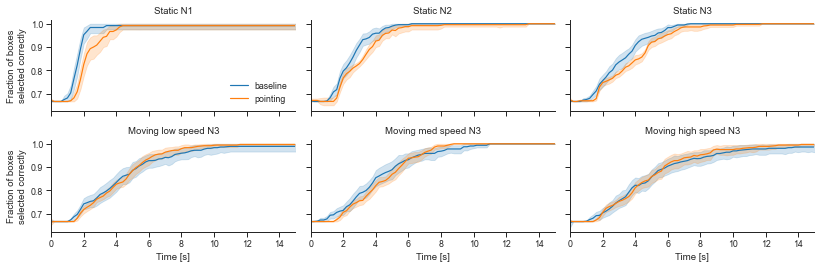

In [75]:
aspect = 2
g = sns.FacetGrid(
    plots,
    row="motion",
    col="level",
    aspect=aspect,
    height=figwidth * 2.3 / aspect / 3,
    xlim=[0, 15],
)
g.map(
    sns.lineplot,
    "time_s",
    "completion",
    "interface",
    hue_order=interfaces,
)
g.set_axis_labels("Time [s]", "Fraction of boxes\nselected correctly")
g.axes[0, 0].legend(loc="lower right", frameon=False)
g.axes[0, 0].set_title("Static N1")
g.axes[0, 1].set_title("Static N2")
g.axes[0, 2].set_title("Static N3")
g.axes[1, 0].set_title("Moving low speed N3")
g.axes[1, 1].set_title("Moving med speed N3")
g.axes[1, 2].set_title("Moving high speed N3")
# g.add_legend(loc="upper center", ncol=2)
# sns.lineplot(data=plots, hue="interface", x="time_s", y="completion")
# plt.gca().set(xlim=[0,10])
g.fig.tight_layout()
g.fig.savefig("cvstime.png", dpi=300)
g.fig.savefig("cvstime.pdf", dpi=300)

### Completion time

In [6]:
ctime = (
    completion.groupby("run")
    .apply(lambda x: x["dt"][(x["correct"] == 1).idxmax()])
    .dt.total_seconds()
    .rename("completion time")
)
ctime = ctime.to_frame().join(key)

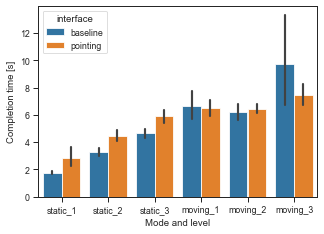

In [7]:
# fig,ax = plt.subplots(figsize=(10,8))
# g = sns.FacetGrid(
#    ctime,
#    # row="subject",
#    aspect=2,
# )
# g.map(
fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=ctime,
    x="scenario",
    y="completion time",
    hue="interface",
    ci=90,
    order=scenarios,
    hue_order=interfaces,
    ax=ax,
)
ax.set(ylabel="Completion time [s]", xlabel="Mode and level")
fig.savefig("ctime.png", dpi=300)
fig.savefig("ctime.pdf", dpi=300)
# g.add_legend()

### Mistakes

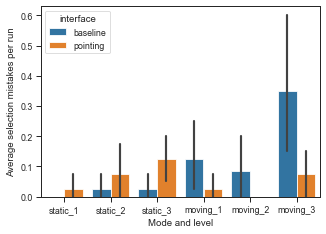

In [8]:
mistakes = completion.groupby("run")["correct"].agg(
    mistakes=lambda x: (x.diff() < 0).sum()
)
mistakes = mistakes.join(key)

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.barplot(
    data=mistakes,
    x="scenario",
    y="mistakes",
    hue="interface",
    ci=90,
    dodge=0.1,
    order=scenarios,
    hue_order=interfaces,
    ax=ax,
)
ax.set(ylabel="Average selection mistakes per run", xlabel="Mode and level")
fig.savefig("mistakes.png", dpi=300)
fig.savefig("mistakes.pdf", dpi=300)

### Questions

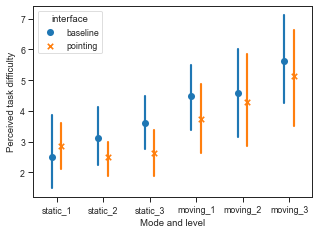

In [9]:
qdf = pd.read_csv("logs_laboratory/questionairs.csv")
qdf["interface"] = qdf["interface"].map(dict(gui="baseline", real="pointing"))
qdf["scenario"] = qdf["mode"] + "_" + qdf["level"].astype(str)
qdf["vote_std"] = qdf.groupby("user")["vote"].transform(
    lambda x: (x - x.mean()) / (x.std())
)

fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.pointplot(
    data=qdf,
    dodge=0.2,
    x="scenario",
    y="vote",
    hue="interface",
    ci=90,
    order=scenarios,
    hue_order=interfaces,
    linestyles="None",
    markers=["o", "x"],
)
plt.gca().set(ylabel="Perceived task difficulty", xlabel="Mode and level")
fig.savefig("questions.png", dpi=300)
fig.savefig("questions.pdf", dpi=300)

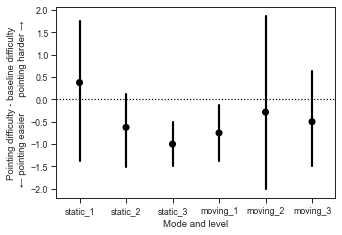

In [10]:
votes = (
    qdf.groupby(["user", "scenario", "mode", "level", "interface"])["vote"]
    .mean()
    .unstack()
)
dvotes = (
    (votes["pointing"] - votes["baseline"]).reset_index().rename(columns={0: "diff"})
)
fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.pointplot(
    data=dvotes,
    x="scenario",
    y="diff",
    ci=90,
    order=scenarios,
    linestyles="None",
    color="k",
)
ax.axhline(y=0, color="k", linestyle=":")
plt.gca().set(
    ylabel="Pointing difficulty - baseline difficulty\n← pointing easier      pointing harder →",
    xlabel="Mode and level",
)
fig.savefig("questions_gap.png", dpi=300)
fig.savefig("questions_gap.pdf", dpi=300)

<ipython-input-45-76fa6d8f1230>:85: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(h_pad=0)


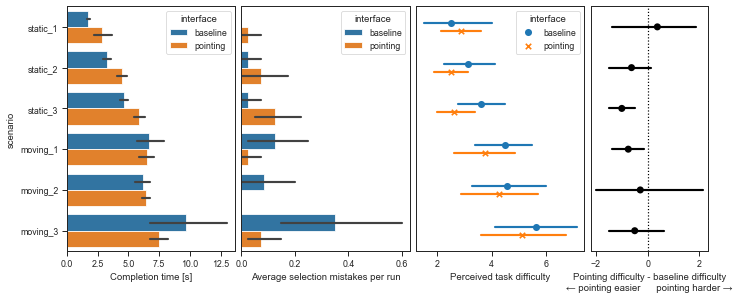

In [45]:
fig, axs = plt.subplots(
    ncols=4,
    sharey=True,
    figsize=(figwidth * 2.3, figwidth * 0.9),
    gridspec_kw=dict(width_ratios=[1, 1, 1, 0.7], wspace=0.04),
)

ax = axs[0]
sns.barplot(
    data=ctime,
    y="scenario",
    x="completion time",
    hue="interface",
    ci=90,
    order=scenarios,
    hue_order=interfaces,
    ax=ax,
)
ax.set(
    xlabel="Completion time [s]",
    ylabel="scenario",
)

ax = axs[1]
sns.barplot(
    data=mistakes,
    y="scenario",
    x="mistakes",
    hue="interface",
    ci=90,
    dodge=0.1,
    order=scenarios,
    hue_order=interfaces,
    ax=ax,
)
ax.set(
    xlabel="Average selection mistakes per run",
    ylabel=None,
)


ax = axs[2]
sns.pointplot(
    data=qdf,
    dodge=0.2,
    y="scenario",
    x="vote",
    hue="interface",
    ci=90,
    order=scenarios,
    hue_order=interfaces,
    linestyles="None",
    markers=["o", "x"],
    ax=ax,
)
ax.set(
    xlabel="Perceived task difficulty",
    ylabel=None,
)

ax = axs[3]
sns.pointplot(
    data=dvotes,
    y="scenario",
    x="diff",
    ci=90,
    order=scenarios,
    linestyles="None",
    color="k",
    ax=ax,
)
ax.axvline(x=0, color="k", linestyle=":")
ax.set(
    xlabel="Pointing difficulty - baseline difficulty\n← pointing easier      pointing harder →",
    ylabel=None,
)

# sns.despine(fig)
# sns.despine(ax=axs[2],left=True)
# axs[2].yaxis.set(visible=False)
# sns.despine(ax=axs[3],left=True)
# axs[3].yaxis.set(visible=False)
for ax in axs[1:]:
    ax.yaxis.set(visible=False)
fig.tight_layout(h_pad=0)
fig.savefig("plots.svg")

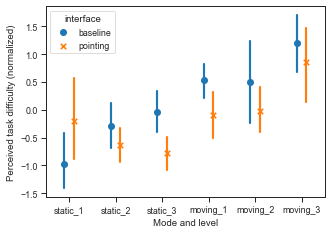

In [11]:
fig, ax = plt.subplots(figsize=(figwidth, figwidth * 0.7))
sns.pointplot(
    data=qdf,
    dodge=0.2,
    x="scenario",
    y="vote_std",
    hue="interface",
    order=scenarios,
    hue_order=interfaces,
    linestyles="None",
    markers=["o", "x"],
)
plt.gca().set(ylabel="Perceived task difficulty (normalized)", xlabel="Mode and level")
fig.savefig("questions_norm.png", dpi=300)
fig.savefig("questions_norm.pdf", dpi=300)

In [12]:
import scipy.stats

(
    scipy.stats.wilcoxon(
        dvotes[dvotes["mode"] == "moving"]["diff"], alternative="less"
    ),
    scipy.stats.wilcoxon(
        dvotes[dvotes["mode"] == "static"]["diff"], alternative="less"
    ),
    scipy.stats.wilcoxon(dvotes["diff"], alternative="less"),
)

C:\Users\Alessandro\miniconda3\envs\geo\lib\site-packages\scipy\stats\morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


(WilcoxonResult(statistic=55.5, pvalue=0.029522647344813552),
 WilcoxonResult(statistic=53.5, pvalue=0.22319534909564193),
 WilcoxonResult(statistic=216.0, pvalue=0.030619877482373527))

In [38]:
votes

interface                      baseline  pointing
user    scenario mode   level                    
ale     moving_1 moving 1             4         3
        moving_2 moving 2             6         3
        moving_3 moving 3             6         4
        static_1 static 1             2         3
        static_2 static 2             3         3
        static_3 static 3             4         3
camila  moving_1 moving 1             8         6
        moving_2 moving 2             9         6
        moving_3 moving 3            10         7
        static_1 static 1             2         4
        static_2 static 2             3         3
        static_3 static 3             3         3
dario   moving_1 moving 1             5         4
        moving_2 moving 2             4         4
        moving_3 moving 3             5         5
        static_1 static 1             3         5
        static_2 static 2             4         4
        static_3 static 3             4         3
gabri   moving_1 moving 1             2         3
        moving_3 moving 3             2         1
        static_1 static 1             1         4
        static_2 static 2             2         2
        static_3 static 3             3         1
jerome  moving_1 moving 1             4         2
        moving_2 moving 2             4         3
        moving_3 moving 3             6         4
        static_1 static 1             1         3
        static_2 static 2             2         3
        static_3 static 3             3         3
jury    moving_1 moving 1             5         4
        moving_2 moving 2             5         4
        moving_3 moving 3             7         7
        static_1 static 1             2         1
        static_2 static 2             2         1
        static_3 static 3             4         2
umberto moving_1 moving 1             6         7
        moving_2 moving 2             2         9
        moving_3 moving 3             7        10
        static_1 static 1             8         2
        static_2 static 2             7         3
        static_3 static 3             7         5
vale    moving_1 moving 1             2         1
        moving_2 moving 2             2         1
        moving_3 moving 3             2         3
        static_1 static 1             1         1
        static_2 static 2             2         1
        static_3 static 3             1         1

In [70]:
subjects = {
    'ale':("M",39),
    'camila':("F",26), 
    'dario':("M",29), 
    'gabri':("M",27), 
    'jerome':("M",40),
    'jury':("M",21),
    'umberto':("M",28),
    'vale':("F",26)
}
table = votes.reset_index().groupby(["user", "mode"]).mean()[interfaces].unstack().swaplevel(
    axis=1
).sort_index(axis=1, level=0)
table = table.join(table.index.to_series().apply(lambda x: pd.Series(index=["age","sex"], data=subjects[x])))
table = table.loc[:,["age","sex"]+list(table.columns[2:4])+list(table.columns[0:2])]
print((table
    .set_index(pd.Index([f"Subj {i}" for i in range(1, 9)]))
    .round(1)).to_latex())

\begin{tabular}{llrrrrr}
\toprule
{} & age &  sex &  (static, baseline) &  (static, pointing) &  (moving, baseline) &  (moving, pointing) \\
\midrule
Subj 1 &   M &   39 &                 3.0 &                 3.0 &                 5.3 &                 3.3 \\
Subj 2 &   F &   26 &                 2.7 &                 3.3 &                 9.0 &                 6.3 \\
Subj 3 &   M &   29 &                 3.7 &                 4.0 &                 4.7 &                 4.3 \\
Subj 4 &   M &   27 &                 2.0 &                 2.3 &                 2.0 &                 2.0 \\
Subj 5 &   M &   40 &                 2.0 &                 3.0 &                 4.7 &                 3.0 \\
Subj 6 &   M &   21 &                 2.7 &                 1.3 &                 5.7 &                 5.0 \\
Subj 7 &   M &   28 &                 7.3 &                 3.3 &                 5.0 &                 8.7 \\
Subj 8 &   F &   26 &                 1.3 &                 1.0 &        

In [42]:
print(
    votes.reset_index()
    .groupby(["user", "mode"])
    .mean()[interfaces]
    .unstack()
    .swaplevel(axis=1)
    
)

\begin{tabular}{lrrrr}
\toprule
mode & \multicolumn{2}{l}{moving} & \multicolumn{2}{l}{static} \\
interface & baseline & pointing & baseline & pointing \\
\midrule
Subj 1 &      5.3 &      3.3 &      3.0 &      3.0 \\
Subj 2 &      9.0 &      6.3 &      2.7 &      3.3 \\
Subj 3 &      4.7 &      4.3 &      3.7 &      4.0 \\
Subj 4 &      2.0 &      2.0 &      2.0 &      2.3 \\
Subj 5 &      4.7 &      3.0 &      2.0 &      3.0 \\
Subj 6 &      5.7 &      5.0 &      2.7 &      1.3 \\
Subj 7 &      5.0 &      8.7 &      7.3 &      3.3 \\
Subj 8 &      2.0 &      1.7 &      1.3 &      1.0 \\
\bottomrule
\end{tabular}



In [44]:
votes.groupby(["user"]).first().index

Index(['ale', 'camila', 'dario', 'gabri', 'jerome', 'jury', 'umberto', 'vale'], dtype='object', name='user')